In [1]:
import sys
print(sys.executable)
print(sys.path)

c:\Users\N1259534\AppData\Local\anaconda3\envs\qaoa_sim\python.exe
['c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\python313.zip', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\DLLs', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim', '', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib\\site-packages', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib\\site-packages\\win32', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib\\site-packages\\Pythonwin']


In [ ]:

import numpy as np
from itertools import combinations
import scipy
import networkx as nx
import matplotlib.pyplot as plt

from QAOA_objective import get_qaoa_objective


In [3]:
import numba.cuda
print(numba.cuda.is_available())

False


In [2]:
#Step 1: Generate terms

N = 6
np.random.seed(1)
terms = [(np.random.normal(), spin_pair) for spin_pair in combinations(range(N), r=2)]
print(terms)

[(1.6243453636632417, (0, 1)), (-0.6117564136500754, (0, 2)), (-0.5281717522634557, (0, 3)), (-1.0729686221561705, (0, 4)), (0.8654076293246785, (0, 5)), (-2.3015386968802827, (1, 2)), (1.74481176421648, (1, 3)), (-0.7612069008951028, (1, 4)), (0.31903909605709857, (1, 5)), (-0.2493703754774101, (2, 3)), (1.462107937044974, (2, 4)), (-2.060140709497654, (2, 5)), (-0.3224172040135075, (3, 4)), (-0.38405435466841564, (3, 5)), (1.1337694423354374, (4, 5))]


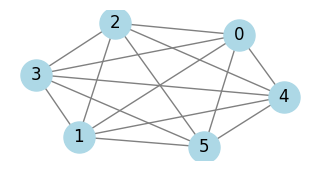

In [3]:
G = nx.Graph()
for weight, (node1, node2) in terms:
    G.add_edge(node1, node2, wight=round(weight, 2))
    
plt.figure(figsize=(3, 1.5))
pos = nx.spring_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=12)


plt.show()

In [4]:
# Step 2: get QAOA objective
# Get objective
p =4
f = get_qaoa_objective(N, terms=terms, parameterization='theta', simulator='qiskit') #simulator='gpu', qiskit

AssertionError: the precomputed_costs still None {precomputed_costs}

In [7]:
# Step 3: Optimize QAOA parameters
import time
start = time.time()
p = 4
initial_gamma = -1*np.linspace(0, 1, p)
initial_beta = np.linspace(1, 0, p)

res = scipy.optimize.minimize(f, np.hstack([initial_gamma, initial_beta]), method='COBYLA', options={'rhobeg': 0.01})
finish = time.time()
elapsed_time = finish - start
print(f"Elapsed time: {elapsed_time:.4f} seconds")

c:\Users\N1259534\AppData\Local\anaconda3\envs\qaoa_sim\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\N1259534\AppData\Local\anaconda3\envs\qaoa_sim\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Elapsed time: 703.5868 seconds


In [8]:
print(f"Expected QAOA solution quality: {res.fun:.5f}")

Expected QAOA solution quality: -57.82774


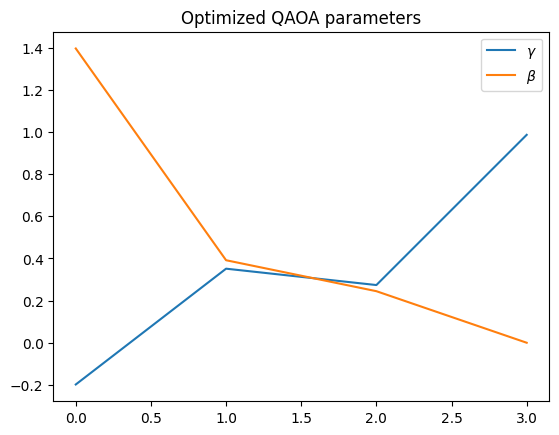

In [12]:
import matplotlib.pyplot as plt
plt.plot(-res.x[:p], label=r"$\gamma$")
plt.plot(res.x[p:], label=r"$\beta$")
plt.title('Optimized QAOA parameters')
plt.legend()

In [10]:
def f_from_terms_ground_truth(s):
    """ground truth for debugging
    """
    out = 0
    for coeff, (i, j) in terms:
        out += coeff * s[i] * s[j]
    return out

In [11]:
print(f"True minimum: {brute_force(f_from_terms_ground_truth, N, minimize=True)[0]:.5f}")


NameError: name 'brute_force' is not defined